In [1]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

import pandas as pd
import swifttools.ukssdc.data.GRB as udg
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')




/Users/hashkar/anaconda3/envs/GRBAI/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
def get_grb_xrt_data(TriggerID) -> pd.DataFrame:
    ''' Returns XRT data frame'''

    if type(TriggerID) is not int:
        raise TypeError("GRB should be an integer.")
 
    try:
        data = udg.getBurstAnalyser(targetID = TriggerID,
                                    instruments=('XRT',),
                                    saveData=False,
                                    returnData=True)
    except:
        xrt_dataframe = pd.DataFrame(columns=["TrigID", "NameGRB", "Time", "TimeNeg", "TimePos", "Flux", "FluxNeg", "FluxPos"])
        return xrt_dataframe

    # raise exception if no GRB is found
    if len(data['Instruments']) == 0:
        #raise ValueError(f"No GRBs found with trigger ID {triggerID}")
        xrt_dataframe = pd.DataFrame(columns=["TrigID", "NameGRB", "Time", "TimeNeg", "TimePos", "Flux", "FluxNeg", "FluxPos"])
        return xrt_dataframe
    # create final dataframe and adding XRT data if available
    xrt_dataframe = pd.DataFrame(columns=["TrigID", "NameGRB", "Time", "TimeNeg", "TimePos", "Flux", "FluxNeg", "FluxPos"])
    xrt_df_list = [xrt_dataframe]
    if "XRTBand_WT_incbad" in data["XRT"]["Datasets"]:
        xrt_wt = data["XRT"]["XRTBand_WT_incbad"][["Time", "TimeNeg", "TimePos", "Flux", "FluxNeg", "FluxPos"]]
        xrt_df_list.append(xrt_wt)
    if "XRTBand_PC_incbad" in data["XRT"]["Datasets"]:
        xrt_pc = data["XRT"]["XRTBand_PC_incbad"][["Time", "TimeNeg", "TimePos", "Flux", "FluxNeg", "FluxPos"]]
        xrt_df_list.append(xrt_pc)

    if len(xrt_df_list) == 1:
        raise ValueError(f"No XRT data found for GRB with trigger ID {triggerID}")

    xrt_dataframe = pd.concat(xrt_df_list)
    xrt_dataframe = xrt_dataframe.assign(TrigID=TriggerID)
    xrt_dataframe.reset_index(drop=True, inplace=True)

    return xrt_dataframe

In [4]:
#Read the file and ID column =
trigger_GRB = []

with open('../datasets/summary_general.txt') as f:
    for line in f:
        trigger = line.split("|")[1].strip()
        trigger_GRB.append(trigger)

trigger_ids = []
for t in trigger_GRB:
    try:
        trigger_ids.append(int(t))
    except ValueError:
        continue  # skip anything that can't be converted

trigger_GRB = np.array(trigger_ids)
print(trigger_GRB)

[1202522 1202386 1201696 ...  100368  100307  100116]


Failed for trigger 1193078: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'
Failed for trigger 1149250: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'
Failed for trigger 1131910: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'
Failed for trigger 1119268: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'
Failed for trigger 1104842: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'
Failed for trigger 1102329: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'
Failed for trigger 1101133: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'
Failed for trigger 1093860: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'
Failed for trigger 1090853: Cannot cast array data from dtype('O') to dt

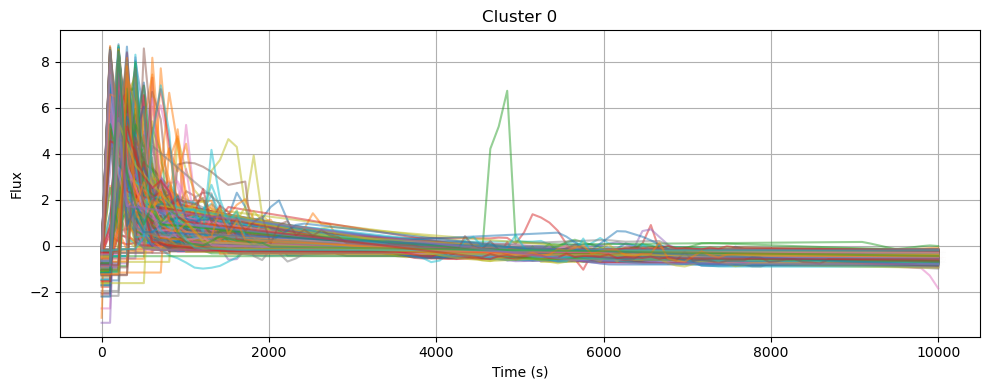

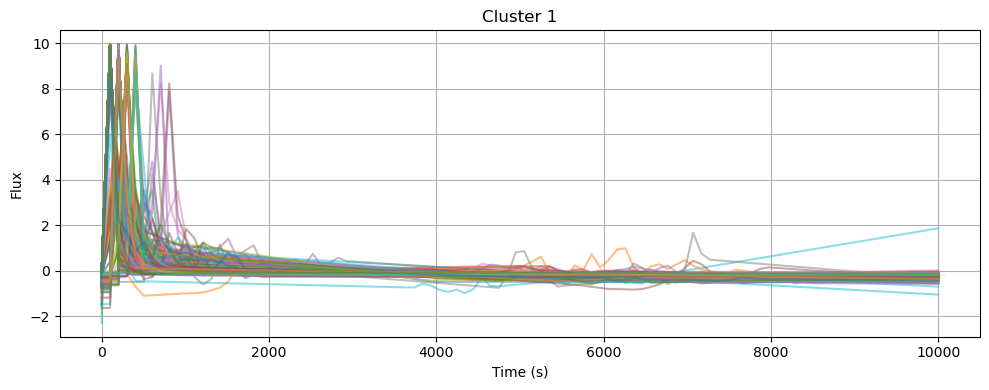

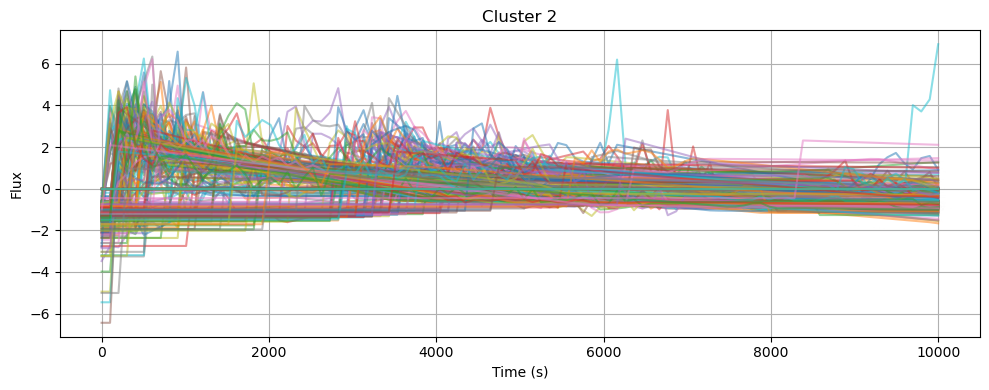

In [7]:
trigger_ids = np.array(trigger_GRB, dtype=int)  # replace with real ones

# Common time grid (to be adjusted)
time_grid = np.linspace(0, 10000, 100)

all_curves = []
valid_triggers = []

for trig_id in trigger_ids:
    try:
        df = get_grb_xrt_data(int(trig_id))
        flux_interp = np.interp(time_grid, df["Time"], df["Flux"], left=np.nan, right=np.nan)
        all_curves.append(flux_interp)
        valid_triggers.append(trig_id)
    except Exception as e:
        print(f"Failed for trigger {trig_id}: {e}")
valid_triggers = np.array(valid_triggers)
# Convert to NumPy array
X = np.array(all_curves)
X = np.nan_to_num(X, nan=0.0) # Needs modification 
X = X[:, :, np.newaxis]  # shape (n_samples, n_timestamps, 1)

# Normalize
X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)

# Cluster
n_clusters = 3
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0) # can also be Euclidian
labels = model.fit_predict(X_scaled)

print(len(X_scaled[labels == 0]))
print(len(X_scaled[labels == 1]))
print(len(X_scaled[labels == 2]))

# Plot clustered light curves
for cluster_id in range(n_clusters):
    plt.figure(figsize=(10, 4))
    for i, x in enumerate(X_scaled[labels == cluster_id]):
        plt.plot(time_grid, x.ravel(), alpha=0.5, label=f"GRB {valid_triggers[labels == cluster_id][i]}")
    plt.title(f"Cluster {cluster_id}")
    plt.xlabel("Time (s)")
    plt.ylabel("Flux")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:


common_time = np.linspace(0, 10000, 100)  # Adjust range as needed
all_flux_interpolated = []
valid_triggers = []

grbs = trigger_ids
trigger_ids = np.array(grbs, dtype=int) 
print(len(trigger_ids))

for trig_id in trigger_ids:
    print(trig_id)
    try:
        df = get_grb_xrt_data(int(trig_id))
        time = df['Time'].values
        flux = df['Flux'].values

        # Interpolate flux onto the common time grid
        interp_func = interp1d(time, flux, bounds_error=False, fill_value=0.0)
        flux_interp = interp_func(common_time)

        all_flux_interpolated.append(flux_interp)
        valid_triggers.append(trig_id)

    except Exception as e:
        print(f"Failed for trigger {trig_id}: {e}")


# Convert to array
X = np.array(all_flux_interpolated)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# --- Step 4: Visualize the t-SNE projection ---
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=40, cmap='viridis')
plt.title("t-SNE projection of GRB Light Curves")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

1586
1202522
1202386
1201696
1200812
1199764
1197311
1197027
1195887
1195733
1194500
1193078
Failed for trigger 1193078: cannot reshape array of size 0 into shape (0,newaxis)
1191188
1189514
1187463
1186032
1185673
1185505
1183217
1182085
1181187
1180410
1177054
1176135
1175438
1173731
1167973
1167288
1167266
1165948
1165354
1164980
1164180
1163401
1163119
1162001
1161390
1161127
1156572
1154967
1154815
1152764
1152509
1150429
1149293
1149250
Failed for trigger 1149250: cannot reshape array of size 0 into shape (0,newaxis)
1145959
1144698
1142997
1142847
1141030
1136936
1131910
Failed for trigger 1131910: cannot reshape array of size 0 into shape (0,newaxis)
1131397
1131029
1129775
1126853
1125809
1123129
1121751
1120270
1119268
Failed for trigger 1119268: cannot reshape array of size 0 into shape (0,newaxis)
1116441
1116441
1116221
1115766
1115156
1114937
1114034
1111672
1110821
1110090
1107466
1107050
1104842
Failed for trigger 1104842: cannot reshape array of size 0 into shape (0,ne

1586
1202522
1202386
1201696
1200812
1199764
1197311
1197027
1195887
1195733
1194500
1193078
Failed for trigger 1193078: cannot reshape array of size 0 into shape (0,newaxis)
1191188
1189514
1187463
1186032
1185673
1185505
1183217
1182085
1181187
1180410
1177054
1176135
1175438
1173731
1167973
1167288
1167266
1165948
1165354
1164980
1164180
1163401
1163119
1162001
1161390
1161127
1156572
1154967
1154815
1152764
1152509
1150429
1149293
1149250
Failed for trigger 1149250: cannot reshape array of size 0 into shape (0,newaxis)
1145959
1144698
1142997
1142847
1141030
1136936
1131910
Failed for trigger 1131910: cannot reshape array of size 0 into shape (0,newaxis)
1131397
1131029
1129775
1126853
1125809
1123129
1121751
1120270
1119268
Failed for trigger 1119268: cannot reshape array of size 0 into shape (0,newaxis)
1116441
1116441
1116221
1115766
1115156
1114937
1114034
1111672
1110821
1110090
1107466
1107050
1104842
Failed for trigger 1104842: cannot reshape array of size 0 into shape (0,ne

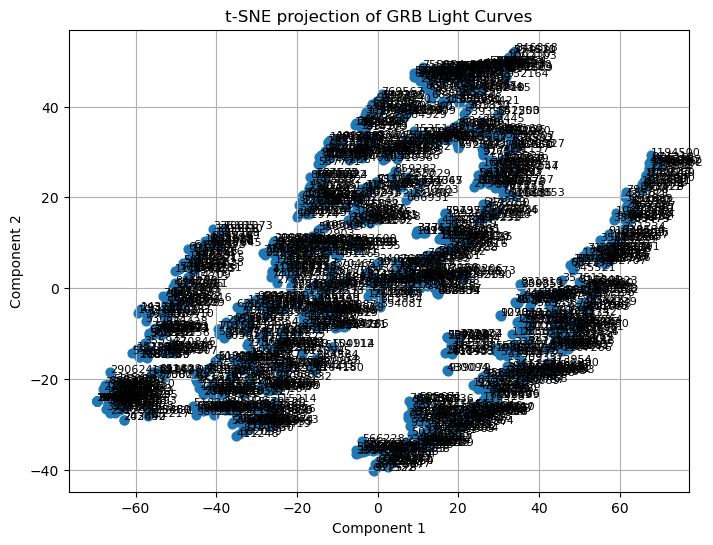

In [5]:


common_time = np.linspace(0, 10000, 100)  # Adjust range as needed
all_flux_interpolated = []
valid_triggers = []

grbs = trigger_ids
trigger_ids = np.array(grbs, dtype=int) 
print(len(trigger_ids))

for trig_id in trigger_ids:
    print(trig_id)
    try:
        df = get_grb_xrt_data(int(trig_id))
        time = df['Time'].values
        flux = df['Flux'].values

        # Interpolate flux onto the common time grid
        interp_func = interp1d(time, flux, bounds_error=False, fill_value=0.0)
        flux_interp = interp_func(common_time)

        all_flux_interpolated.append(flux_interp)
        valid_triggers.append(trig_id)

    except Exception as e:
        print(f"Failed for trigger {trig_id}: {e}")


# Convert to array
X = np.array(all_flux_interpolated)

# Scale the data
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
X_embedded = tsne.fit_transform(X)

# --- Step 4: Visualize the t-SNE projection ---
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=40, cmap='viridis')
for i, trig_id in enumerate(valid_triggers):
    plt.text(X_embedded[i, 0], X_embedded[i, 1], str(trig_id), fontsize=8)
plt.title("t-SNE projection of GRB Light Curves")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

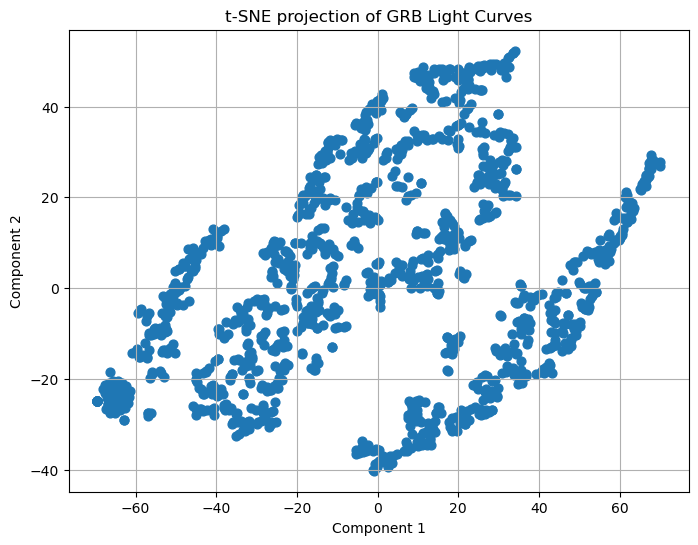

In [6]:
# --- Step 4: Visualize the t-SNE projection ---
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=40, cmap='viridis')
plt.title("t-SNE projection of GRB Light Curves")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()